In [ ]:
#Sử dụng Paris Dataset gồm 6412 bức ảnh được thu thập bởi Flicks quanh Paris
!wget http://www.robots.ox.ac.uk/~vgg/data/parisbuildings/paris_1.tgz
!tar -xzvf paris_1.tgz

In [ ]:
#Hàm để xóa bớt ảnh trong dataset (OPTIONAL)
import os
import random
from shutil import move

def remove_images(directory, num_to_keep=50):
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)

        if os.path.isdir(category_path):
            # Lấy danh sách tất cả các tệp trong thư mục
            all_files = os.listdir(category_path)
            # Lọc ra chỉ các tệp hình ảnh (vd: .jpg, .png)
            image_files = [file for file in all_files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]

            # Chọn ngẫu nhiên số lượng ảnh để giữ lại
            images_to_keep = random.sample(image_files, min(num_to_keep, len(image_files)))

            # Xóa ảnh không được giữ lại
            for file in all_files:
                file_path = os.path.join(category_path, file)
                if file not in images_to_keep and os.path.isfile(file_path):
                    os.remove(file_path)

# Đường dẫn đến thư mục chứa Paris dataset
paris_dataset_directory = "/content/paris"

# Chỉ giữ lại 20 ảnh mỗi mục
remove_images(paris_dataset_directory, num_to_keep=20)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


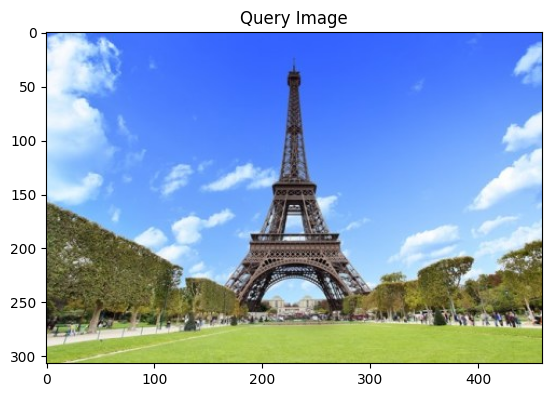

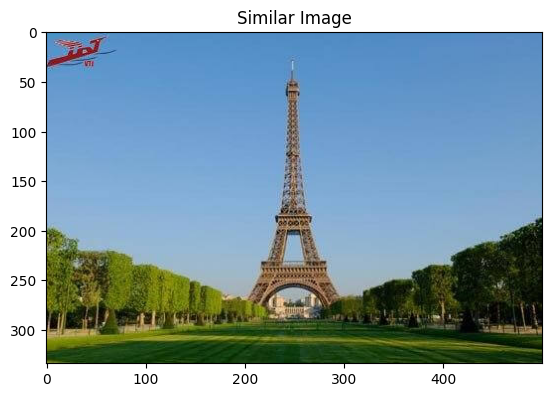

In [ ]:

import cv2
import os
import random
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard

# Hàm để trích xuất đặc trưng cục bộ SIFT từ hình ảnh
def extract_sift_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create()
    key_points, descriptors = sift.detectAndCompute(image, None)
    return key_points, descriptors

# Hàm lấy tất cả hình ảnh từ các thư mục con của thư mục chứa dataset
def get_all_image_paths(directory):
    image_paths = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                image_paths.append(os.path.join(root, file))

    return image_paths

# Đường dẫn đến thư mục chứa Paris dataset
image_directory = "/content/paris"

# Lấy tất cả các đường dẫn đến hình ảnh từ tệp con
image_paths = get_all_image_paths(image_directory)

# Kiểm tra và loại bỏ các tệp không phải hình ảnh
image_paths = [path for path in image_paths if path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]


# Phân chia tập dữ liệu thành tập huấn luyện và tập kiểm thử
train_ratio = 0.8
num_train = int(train_ratio * len(image_paths))
random.shuffle(image_paths)
train_paths = image_paths[:num_train]
test_paths = image_paths[num_train:]

# Số lượng visual words trong codebook (k)
k = 64

# Trích xuất đặc trưng cục bộ từ tất cả các hình ảnh
all_features = []
for path in image_paths:
    key_points, descriptors = extract_sift_features(path)
    if descriptors is not None:
        all_features.extend(descriptors)

# Chuyển danh sách đặc trưng thành một mảng NumPy
all_features = np.array(all_features)

# Sử dụng K-Means để tạo codebook
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(all_features)

# Bộ từ điển hình ảnh (codebook) là các điểm trung tâm của các cụm (clusters)
codebook = kmeans.cluster_centers_

# Hàm để tính VLAD vector cho một hình ảnh
def compute_vlad_vector(image_path, codebook):
    key_points, descriptors = extract_sift_features(image_path)
    vlad_vector = np.zeros((k, descriptors.shape[1]), dtype=np.float32)

    # Gán các đặc trưng cục bộ cho visual words gần nhất
    labels = kmeans.predict(descriptors)

    for i in range(len(key_points)):
        vlad_vector[labels[i]] += descriptors[i] - codebook[labels[i]]

    # Chuẩn hóa VLAD vector bằng cách tính L2-norm (Euclidean norm)
    vlad_vector = vlad_vector.flatten()
    vlad_vector /= np.linalg.norm(vlad_vector)

    return vlad_vector

# Tính VLAD vectors cho tất cả hình ảnh trong danh sách
vlad_vectors = []
for path in image_paths:
    vlad_vector = compute_vlad_vector(path, codebook)
    vlad_vectors.append(vlad_vector)

# Chuyển danh sách VLAD vectors thành mảng NumPy
vlad_vectors = np.array(vlad_vectors)

# Số chiều sau khi giảm chiều dữ liệu bằng PCA
compo = len(image_paths)
n_components = compo

# Áp dụng PCA để giảm chiều dữ liệu cho cả tập huấn luyện và tập kiểm thử
pca = PCA(n_components=n_components)
all_vlad_vectors_reduced = pca.fit_transform(vlad_vectors)

# Tách lại tập huấn luyện và tập kiểm thử
train_vlad_vectors_reduced = all_vlad_vectors_reduced[:num_train]
test_vlad_vectors_reduced = all_vlad_vectors_reduced[num_train:]

# Xây dựng cây KD-Tree cho tập huấn luyện
train_kdtree = cKDTree(train_vlad_vectors_reduced)

# Hàm để hiển thị vector mô tả hình ảnh
def display_image_with_vector(image_path, vlad_vector, title):
    image = cv2.imread(image_path)
    plt.figure()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

# Hàm để tìm và hiển thị hình ảnh tương tự
def search_similar_images(query_vector, kdtree, vlad_vectors_reduced,
                          num_results=1):
    _, indices = kdtree.query(query_vector, num_results)

    if num_results == 1:
        idx = int(indices[0])  # Truy cập chỉ mục đầu tiên
        image_path = image_paths[idx]
        display_image_with_vector(image_path,
                        vlad_vectors_reduced[idx], "Similar Image")
    else:
        for i in range(num_results):
            idx = int(indices[i][0])
            image_path = image_paths[idx]
            display_image_with_vector(image_path,
                vlad_vectors_reduced[idx],f"Similar Image {i + 1}")

# Hàm để tìm đường dẫn của hình ảnh tương tự
def search_similar_images_path(query_vector, kdtree, vlad_vectors_reduced,
                          num_results=1):
    _, indices = kdtree.query(query_vector, num_results)

    if num_results == 1:
        idx = int(indices[0])  # Truy cập chỉ mục đầu tiên
        image_path = image_paths[idx]
        return image_path
    else:
        for i in range(num_results):
            idx = int(indices[i][0])
            image_path = image_paths[idx]
            return image_path
# Tạo vector mô tả cho hình ảnh đã chọn ngẫu nhiên trong tập kiểm thử
query_image_path = random.choice(test_paths)
query_vlad_vector = compute_vlad_vector(query_image_path, codebook)
query_vlad_vector = query_vlad_vector.reshape(1, -1)
query_vlad_vector_reduced = pca.transform(query_vlad_vector)

# Hiển thị vector mô tả của hình ảnh đã chọn ngẫu nhiên
display_image_with_vector(query_image_path, query_vlad_vector_reduced, "Query Image")

# Tìm và hiển thị hình ảnh tương tự trong tập kiểm thử
search_similar_images(query_vlad_vector_reduced, train_kdtree, train_vlad_vectors_reduced, num_results=1)

def compute_accuracy(kdtree, vlad_vectors_reduced, test_paths, codebook, pca):
    correct_matches = 0
    total_queries = len(test_paths)

    for query_image_path in test_paths:
        query_vlad_vector = compute_vlad_vector(query_image_path, codebook)
        query_vlad_vector = query_vlad_vector.reshape(1, -1)
        query_vlad_vector_reduced = pca.transform(query_vlad_vector)

        target = search_similar_images_path(query_vlad_vector_reduced, train_kdtree, train_vlad_vectors_reduced, num_results=1)

        if os.path.dirname(query_image_path) == os.path.dirname(target):
                correct_matches += 1

    accuracy = correct_matches / total_queries

    return accuracy

accuracy = compute_accuracy(train_kdtree, test_vlad_vectors_reduced, test_paths, codebook, pca)
print(f"Accuracy: {accuracy * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


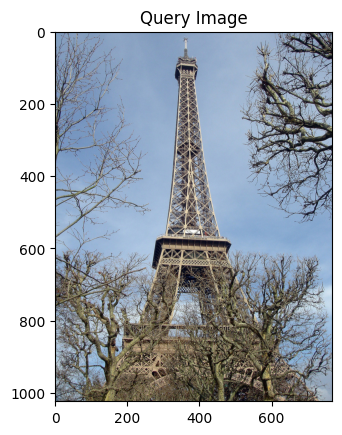

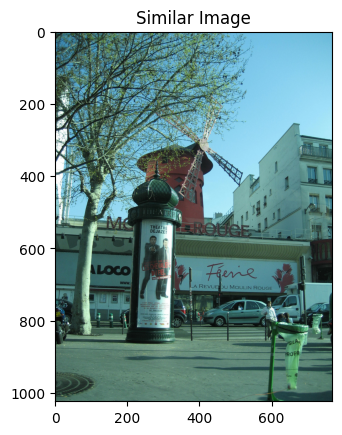

Accuracy: 45.83%


In [ ]:
# Code tính độ chính xác của phương pháp bof trong việc tìm kiếm hình ảnh

import cv2
import os
import random
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

# Hàm để trích xuất đặc trưng cục bộ SIFT từ hình ảnh
def extract_sift_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create()
    key_points, descriptors = sift.detectAndCompute(image, None)
    return key_points, descriptors

def get_all_image_paths(directory):
    image_paths = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                image_paths.append(os.path.join(root, file))

    return image_paths

# Đường dẫn đến thư mục chứa Paris dataset
image_directory = "/content/paris"

# Lấy tất cả các đường dẫn đến hình ảnh từ tệp con
image_paths = get_all_image_paths(image_directory)

# Kiểm tra và loại bỏ các tệp không phải hình ảnh
image_paths = [path for path in image_paths if path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]

# Phân chia tập dữ liệu thành tập huấn luyện và tập kiểm thử
train_ratio = 0.8
num_train = int(train_ratio * len(image_paths))
random.shuffle(image_paths)
train_paths = image_paths[:num_train]
test_paths = image_paths[num_train:]

# Số lượng visual words trong codebook (k)
k = 64

# Trích xuất đặc trưng cục bộ từ tất cả các hình ảnh
all_features = []
for path in image_paths:
    key_points, descriptors = extract_sift_features(path)
    if descriptors is not None:
        all_features.extend(descriptors)

# Chuyển danh sách đặc trưng thành một mảng NumPy
all_features = np.array(all_features)

# Sử dụng K-Means để tạo codebook
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(all_features)

# Bộ từ điển hình ảnh (codebook) là các điểm trung tâm của các cụm (clusters)
codebook = kmeans.cluster_centers_

# Hàm để tính BoF vector cho một hình ảnh
def compute_bof_vector(image_path, codebook):
    key_points, descriptors = extract_sift_features(image_path)
    bof_vector = np.zeros(k, dtype=np.float32)

    # Gán các đặc trưng cục bộ cho visual words gần nhất
    labels = kmeans.predict(descriptors)

    # Đếm tần suất xuất hiện của từng visual word
    for label in labels:
        bof_vector[label] += 1

    # Chuẩn hóa vector BoF
    bof_vector /= np.sum(bof_vector)

    return bof_vector

# Tính BoF vectors cho tất cả hình ảnh trong danh sách
bof_vectors = []
for path in image_paths:
    bof_vector = compute_bof_vector(path, codebook)
    bof_vectors.append(bof_vector)

# Chuyển danh sách BoF vectors thành mảng NumPy
bof_vectors = np.array(bof_vectors)

# Xây dựng cây KD-Tree cho tập huấn luyện
train_kdtree = cKDTree(bof_vectors[:num_train])

# Hàm để hiển thị vector mô tả hình ảnh
def display_image_with_vector(image_path, bof_vector, title):
    image = cv2.imread(image_path)
    plt.figure()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

# Hàm để tìm và hiển thị hình ảnh tương tự
def search_similar_images(query_vector, kdtree, bof_vectors,
                          num_results=1):
    _, indices = kdtree.query(query_vector, num_results)

    if num_results == 1:
        idx = int(indices[0])  # Truy cập chỉ mục đầu tiên
        image_path = image_paths[idx]
        display_image_with_vector(image_path,
                        bof_vectors[idx], "Similar Image")
    else:
        for i in range(num_results):
            idx = int(indices[i][0])
            image_path = image_paths[idx]
            display_image_with_vector(image_path,
                bof_vectors[idx], f"Similar Image {i + 1}")

def search_similar_images_path(query_vector, kdtree, bof_vectors,
                          num_results=1):
    _, indices = kdtree.query(query_vector, num_results)

    if num_results == 1:
        idx = int(indices[0])  # Truy cập chỉ mục đầu tiên
        image_path = image_paths[idx]
        return image_path
    else:
        for i in range(num_results):
            idx = int(indices[i][0])
            image_path = image_paths[idx]
            return image_path

# Tạo vector mô tả cho hình ảnh đã chọn ngẫu nhiên trong tập kiểm thử
query_image_path = random.choice(test_paths)
query_bof_vector = compute_bof_vector(query_image_path, codebook)
query_bof_vector = query_bof_vector.reshape(1, -1)

# Hiển thị vector mô tả của hình ảnh đã chọn ngẫu nhiên
display_image_with_vector(query_image_path, query_bof_vector, "Query Image")

# Tìm và hiển thị hình ảnh tương tự trong tập kiểm thử
search_similar_images(query_bof_vector, train_kdtree, bof_vectors, num_results=1)

def compute_accuracy(kdtree, bof_vectors, test_paths, codebook):
    correct_matches = 0
    total_queries = len(test_paths)

    for query_image_path in test_paths:
        query_bof_vector = compute_bof_vector(query_image_path, codebook)
        query_bof_vector = query_bof_vector.reshape(1, -1)

        target = search_similar_images_path(query_bof_vector, kdtree, bof_vectors, num_results=1)

        if os.path.dirname(query_image_path) == os.path.dirname(target):
                correct_matches += 1

    accuracy = correct_matches / total_queries

    return accuracy

accuracy = compute_accuracy(train_kdtree, bof_vectors, test_paths, codebook)
print(f"Accuracy: {accuracy * 100:.2f}%")
